<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BCS" data-toc-modified-id="BCS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BCS</a></span><ul class="toc-item"><li><span><a href="#Eigenvalues" data-toc-modified-id="Eigenvalues-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Eigenvalues</a></span></li></ul></li><li><span><a href="#VQE-From-Scratch-Using-Aqua" data-toc-modified-id="VQE-From-Scratch-Using-Aqua-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>VQE From Scratch Using Aqua</a></span><ul class="toc-item"><li><span><a href="#Construct-Expectation" data-toc-modified-id="Construct-Expectation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Construct Expectation</a></span></li></ul></li><li><span><a href="#Hamiltonian-Simulation" data-toc-modified-id="Hamiltonian-Simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hamiltonian Simulation</a></span></li><li><span><a href="#VQE" data-toc-modified-id="VQE-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>VQE</a></span></li></ul></div>

# BCS

Using the Paper by [Wu et al.](https://arxiv.org/abs/quant-ph/0108110), we have that:

The BCS hamiltonian is:

$$H_{BCS} = \sum_{m=1}^N \frac{\epsilon_m}{2} ( n_m^F + n_{-m}^F ) + \sum_{m,k=1}^N V^{+}_{ml} c^\dagger_m c^\dagger_{-m} c_{-l}c_l$$

Where $n_{\pm m}^F = c^\dagger_{\pm m} c_{\pm m}$, and the matrix elements $V^+_{ml} = \langle m, -m| V | l, -l \rangle$.

Which is mapped into:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m + \sum_{r= \pm l} \sum_{l>m=1}^N \frac{V_{ml}^r}{2} ( \sigma^x_m \sigma^x_l + r \sigma^y_m \sigma^y_l )$$

where $\epsilon_m = \epsilon_m + V^+_{mm}$ and $V^-_{ml} = 0$ for the BCS Hamiltonian, thus:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m +  \sum_{l>m=1}^N \frac{V_{ml}}{2} ( \sigma^x_m \sigma^x_l +  \sigma^y_m \sigma^y_l )$$

$l \ \mathrm{and} \ m$ now denote both state and qubit indices. In this case the qubit state space $H_P = Span \{ |0 \rangle, \sigma^+_m |0 \rangle, \sigma_l^+ \sigma_m^+ |0 \rangle, \dots   \}$ is mapped into a subspace where $n_m^F = n^F_{-m}$. Considering $V_{ml} = V$, we have that:

$$
H_p = \hbar \bigg[ \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma_z^m + \frac{V}{2} \sum_{l>m=1}^N (\sigma_x^m \sigma_x^l + \sigma_y^m \sigma_y^l) \bigg]
$$
[Aqua Operator Flow Reference](https://github.com/dongreenberg/aqua_talks/blob/master/Understanding%20Aqua's%20Operator%20Flow.ipynb)

In [1]:
import numpy as np
from qiskit.aqua.operators import OperatorBase, ListOp, PrimitiveOp, PauliOp
from qiskit.aqua.operators import I, X, Y, Z
from qiskit.quantum_info import Pauli
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt

def BCS_hamiltonian(epsilons, V):
    return 1/2*((epsilons[0]*I^Z) + (epsilons[1]*Z^I) + V*((X^X) + (Y^Y)))

In [25]:
EPSILONS = [1,1]
V = 1
hamiltonian = BCS_hamiltonian(EPSILONS, V)
print(hamiltonian)

0.5 * SummedOp([
  IZ,
  ZI,
  XX,
  YY
])


## Eigenvalues

In [160]:
eigenvalues, _ = np.linalg.eigh(hamiltonian.to_matrix())
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [-2. -1.  1.  2.]


# VQE From Scratch Using Aqua

## Construct Expectation

In [92]:
var_form_params = sorted(var_form.parameters, key=lambda p: p.name)
parameter = [1]*len(var_form_params)
param_dict = dict(zip(var_form_params, parameter))
wave_function = var_form.assign_parameters(param_dict)

In [98]:
from qiskit.aqua.operators import ExpectationFactory, StateFn, CircuitStateFn
expectation = ExpectationFactory.build(operator=hamiltonian,
                                       backend=QuantumInstance(Aer.get_backend('statevector_simulator'))
                                      )
observable_meas = expectation.convert(StateFn(hamiltonian, is_measurement=True))
ansatz_circuit_op = CircuitStateFn(wave_function)

In [131]:
construct_expectation = observable_meas.compose(ansatz_circuit_op).reduce()
expect_op = construct_expectation.to_circuit_op()

In [132]:
expect_op

ComposedOp([OperatorStateFn(MatrixOp(Operator([[ 2.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  4.+0.j,  0.+0.j],
          [ 0.+0.j,  4.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -2.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2)), coeff=0.5), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fa3aceb0518>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [127]:
circuits = []

# recursively extract circuits
def extract_circuits(op):
    if isinstance(op, CircuitStateFn):
        circuits.append(op.primitive)
    elif isinstance(op, ListOp):
        for op_i in op.oplist:
            extract_circuits(op_i)

extract_circuits(expect_op)

In [133]:
from qiskit.aqua.operators import CircuitSampler
circuit_sampler = CircuitSampler(QuantumInstance(Aer.get_backend('statevector_simulator')))

In [139]:
sampled_expect_op = circuit_sampler.convert(expect_op)
means = np.real(sampled_expect_op.eval())

In [140]:
means

0.5179023763441942

# Hamiltonian Simulation

In [89]:
from qiskit.aqua.operators import PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki
from qiskit.aqua.operators import StateFn, Plus, Zero, One, Minus, PauliExpectation, CX
from qiskit.circuit import Parameter
from qiskit import BasicAer

In [130]:
# Initial State 
init_state = (Plus^Zero)

# Time evolution operator
evolution_param = Parameter("t")
evolution_op = (evolution_param * hamiltonian).exp_i()

# Measurement of the Hamiltonian with the time evolved state
evo_and_meas = StateFn(hamiltonian).adjoint() @ evolution_op @ init_state

# Trotterization
trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(evo_and_meas)

# Diagonalize the measurement
diagonalized_meas_op = PauliExpectation().convert(trotterized_op)

# Create an array to represent time and apply to the circuit
n_points = 10
time_array = list(np.linspace(0, 1/V, n_points))
expectations = diagonalized_meas_op.bind_parameters({evolution_param: time_array})

# Define Backend
backend = BasicAer.get_backend("statevector_simulator")

# Use CircuitSampler for getting energy values
sampler = CircuitSampler(backend=backend)
sampled_expectations = sampler.convert(expectations)
sampled_energies = sampled_expectations.eval()
print(f"Time:\n {time_array}")
print(f"Sampled energies after Trotterization:\n {np.real(sampled_energies)}")

Time:
 [0.0, 0.05555555555555555, 0.1111111111111111, 0.16666666666666666, 0.2222222222222222, 0.2777777777777778, 0.3333333333333333, 0.38888888888888884, 0.4444444444444444, 0.5]
Sampled energies after Trotterization:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


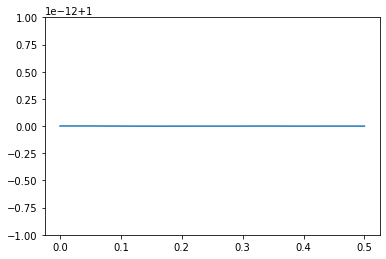

In [131]:
plt.plot(time_array, np.real(sampled_energies))
plt.show()

# VQE

In [24]:
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal

var_form = TwoLocal(len(EPSILONS), ['ry','rz'], 'cx', reps=3)
optimizer = COBYLA(maxiter=100, tol=0.001)

In [25]:
vqe = VQE(hamiltonian, var_form, optimizer)

In [26]:
from qiskit import Aer
from qiskit.aqua import QuantumInstance
result = vqe.run(QuantumInstance(Aer.get_backend('statevector_simulator')))
print(f"Resulting energy: {np.real(result['eigenvalue'])}")

Resulting energy: -1.9975799182567784


In [27]:
import warnings
warnings.filterwarnings("ignore")
from qiskit.aqua.algorithms import ExactEigensolver

def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    # print('Reference value: {}'.format(ref))
    return ref

def error(predicted_value, real_value):
    return np.abs(predicted_value - real_value)

ref = exact_solver(hamiltonian)
print(f'Exact energy is: {np.round(ref,4)}')

Exact energy is: -2.0


In [21]:
print('Error:', error(result['eigenvalue'], ref))

Error: 0.0016814406050968955


In [84]:
var_form = TwoLocal(len(EPSILONS), ['ry','rz'], 'cx', reps=3)
optimizer = COBYLA(maxiter=0, tol=0.001)
vqe = VQE(hamiltonian, var_form, optimizer)
result = vqe.run(QuantumInstance(Aer.get_backend('statevector_simulator')))
print(f"Resulting energy: {np.real(result['eigenvalue'])}")

Resulting energy: -0.5471154749292751
